# Project Part 1

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/sgeinitz/cs39aa_project/blob/main/project_part1.ipynb)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgeinitz/cs39aa_project/blob/main/project_part1.ipynb)



## Introduction/Background

In this project I will attempting to train a model to predict news media bias. In order to do this I will be utilizing the dataset NLPCSS-20 from the Association for Computational Linguistics which can be found on Github. The dataset is a collection or corpus contrived of 6,964 news articles. The labels of how we describe the corpus are the following:
- title: title of news article
- content: content of news article
- source: source of the content
- allsides-bias: bias (left, center or right)
- misc: aurhor, date, etc
- adfontes_fair: how fair is the news article (bias, neutral or unknown)
- adfontes_political: how political bias skewed the article is (bias, neutral or unknown)
- event_id:event id

This is a text classification problem as how we are trying to classify combination of strings that demonstrate wheter a news content is politically bias or not. The combination of strings is the content itself, it is then labeled with how bias that content is. 


## Exploratory Data Analysis

First step is to analyze the data we have in order to figure out how our data looks like and what it is trying to tell us.

The dataset comes in a Json file so there are extra steps as to converting the data into a dataframe.

In [1]:
# import all of the python modules/packages you'll need here
import nltk
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#nltk.download('wordnet')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

As we can oberseve the json data set is not able to be formatted into a dataframe, this is becuase its format is unsupported by pandas and will have to be reformated.

In [2]:
# convert json file to dataframe
# path has original data, path2 is a small excerpt from og data w/ a fix to check if it is able to reformatt into df
path= "NLPCSS-20-main/data/released_data.json"
path2= "NLPCSS-20-main/data/example.json"

# test_df = pd.read_json(path, orient='records')
test_df2 = pd.read_json(path2, orient='records')

# print(test_df)
print (test_df2)

             source                                              title  \
0          Fox News  Trump blasts Howard Schultz, says ex-Starbucks...   
1         USA TODAY  Trump blasts former Starbucks CEO Howard Schul...   
2  Washington Times  Mick Mulvaney: Trump to secure border 'with or...   
3  Washington Times  Trump says 'we'll do the emergency' if border ...   

   event_id adfontes_fair adfontes_political    allsides_bias  \
0         0          bias               bias   From the Right   
1         0          bias            neutral  From the Center   
2         0          bias            neutral   From the Right   
3         0          bias            neutral   From the Right   

                                             content  \
0  Obama administration alum Roger Fisk and Repub...   
1  WASHINGTON – President Donald Trump took a swi...   
2  Acting White House chief of staff Mick Mulvane...   
3  President Trump repeated his vow Friday to dec...   

                      

In [3]:
#path to reformatted json file
path_data= 'NLPCSS-20-main/data/data.json'
#reformatt json file
with open(path, 'r') as rf:
    with open(path_data, 'w') as wf:
        #add [ at the beginning of the corpus
        wf.write('[\n')
        #add a comma at the end of each line
        lines= rf.read().splitlines()
        new_line= ',\n'.join(lines)
        wf.write(new_line)
        #add ] at the end of the corpus
        wf.write('\n]')
        


We can now convert data into a pandas dataframe and checkout initial observations

In [4]:
"""Convert reformatted dataset into dataframe"""
df = pd.read_json(path_data, orient='records')

df.head(3)

,source,title,event_id,adfontes_fair,adfontes_political,allsides_bias,content,misc
0,Fox News,"Trump blasts Howard Schultz, says ex-Starbucks...",0,bias,bias,From the Right,Obama administration alum Roger Fisk and Repub...,"{'time': '2019-01-28 16:10:44.680484', 'topics..."
1,USA TODAY,Trump blasts former Starbucks CEO Howard Schul...,0,bias,neutral,From the Center,WASHINGTON – President Donald Trump took a swi...,"{'time': 'None', 'topics': 'Election: Presiden..."
2,Washington Times,Mick Mulvaney: Trump to secure border 'with or...,0,bias,neutral,From the Right,Acting White House chief of staff Mick Mulvane...,"{'time': 'None', 'topics': 'White House', 'aut..."


Now lets do some basic pandas data exploration to get a sense of the data.
There are 7775 observations with 8 columns, but it seems as we might not have to use all columns.

In [5]:
print(df.info())
print("\nThe shape of dataset as of right now is ", df.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7775 entries, 0 to 7774
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   source              7775 non-null   object
 1   title               7775 non-null   object
 2   event_id            7775 non-null   int64 
 3   adfontes_fair       7775 non-null   object
 4   adfontes_political  7775 non-null   object
 5   allsides_bias       7775 non-null   object
 6   content             7775 non-null   object
 7   misc                7775 non-null   object
dtypes: int64(1), object(7)
memory usage: 486.1+ KB
None

The shape of dataset as of right now is  (7775, 8)


We want to deal with a simple model first so we will proceed to only use 'content' and 'allsides_bias' first, and we can drop every other column.

In [6]:
df.drop(columns=['source','title','event_id','misc','adfontes_fair','adfontes_political'], inplace=True)
#lowercase the content column
df['content']= df['content'].str.lower()
df.head()

,allsides_bias,content
0,From the Right,obama administration alum roger fisk and repub...
1,From the Center,washington – president donald trump took a swi...
2,From the Right,acting white house chief of staff mick mulvane...
3,From the Right,president trump repeated his vow friday to dec...
4,From the Center,president donald trump has yielded to politica...


Lets see the shape and columns of our remodified data frame as well as the unique values of our allsides_bias and its value counts.

In [7]:
print(df.info())
print("\nThe shape of dataset as of right now is ", df.shape,"\n")
print("The unique values for allsides_bias is:\n",df.allsides_bias.unique(),"\n")
df.allsides_bias.value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7775 entries, 0 to 7774
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   allsides_bias  7775 non-null   object
 1   content        7775 non-null   object
dtypes: object(2)
memory usage: 121.6+ KB
None

The shape of dataset as of right now is  (7775, 2) 

The unique values for allsides_bias is:
 ['From the Right' 'From the Center' 'From the Left'] 



From the Left      0.473826
From the Right     0.366688
From the Center    0.159486
Name: allsides_bias, dtype: float64

We can see most results come from the left, around 37% com from the right and 15% are center biased.

Now lets check for empty values in both columns.

In [8]:
null_entries= df.isnull().sum()
null_entries

allsides_bias    0
content          0
dtype: int64

So our data frame as of now has two rows, and both contain values that are not empty or NaN.

Lets take a look into the stopwords vs non-stopwords within the dataset

Bar graph of amt of stopwords in content:



<BarContainer object of 10 artists>

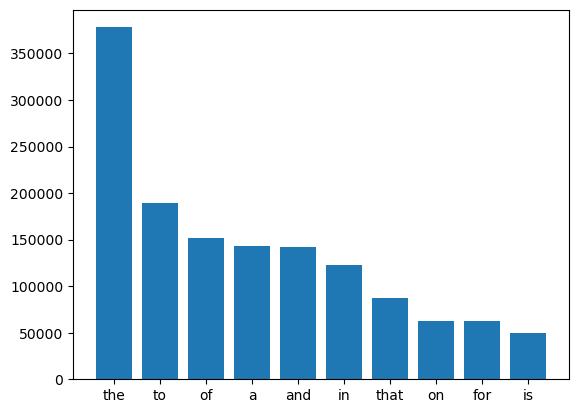

In [9]:
"Create a corpus without stopwords"
from nltk.corpus import stopwords
stops= set(stopwords.words('english'))

corpus=[]
new= df['content'].str.split()
new= new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic= defaultdict(int)
for word in corpus:
    if word in stops:
        dic[word]+=1

top= sorted(dic.items(), key=lambda x:x[1], reverse= True)[:10]
x,y= zip(*top)
print("Bar graph of amt of stopwords in content:\n")
plt.bar(x,y)

<AxesSubplot:>

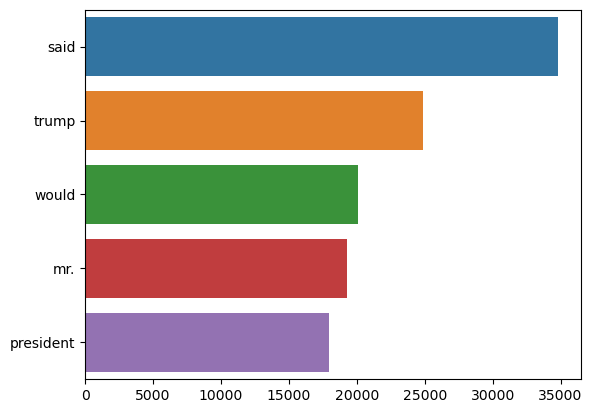

In [10]:
"create a chart to show number of occurences of words in dataset"
from collections import Counter

counter= Counter(corpus)
most= counter.most_common()

x,y= [], []
for word, count in most[:40]:
    if (word not in stops):
        x.append(word)
        y.append(count)

sns.barplot(x=y, y=x)

# Project Part II

Before making a baseline for the model, we will want to process the dataset we will have to tokenize our data.

In [11]:
"Using nltk tokenize the dataset"
from nltk.tokenize import word_tokenize
nltk.download('punkt')

df['tokens_raw']= df['content'].apply(word_tokenize)
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     /home/msalvador45/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,allsides_bias,content,tokens_raw
0,From the Right,obama administration alum roger fisk and repub...,"[obama, administration, alum, roger, fisk, and..."
1,From the Center,washington – president donald trump took a swi...,"[washington, –, president, donald, trump, took..."
2,From the Right,acting white house chief of staff mick mulvane...,"[acting, white, house, chief, of, staff, mick,..."
3,From the Right,president trump repeated his vow friday to dec...,"[president, trump, repeated, his, vow, friday,..."
4,From the Center,president donald trump has yielded to politica...,"[president, donald, trump, has, yielded, to, p..."


As well as removing stopwords from the dataset

In [12]:
import re

chars2remove= set(['.','!','/','?','#','-']) 
#stops contains our stopwords
df['tokens_raw']= df['tokens_raw'].apply(lambda x: [w for w in x if w not in stops])
df['tokens_raw']= df['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove])
df['tokens_raw']= df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^http',w)])
df['tokens_raw']= df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^@', w)])
df.head()

,allsides_bias,content,tokens_raw
0,From the Right,obama administration alum roger fisk and repub...,"[obama, administration, alum, roger, fisk, rep..."
1,From the Center,washington – president donald trump took a swi...,"[washington, –, president, donald, trump, took..."
2,From the Right,acting white house chief of staff mick mulvane...,"[acting, white, house, chief, staff, mick, mul..."
3,From the Right,president trump repeated his vow friday to dec...,"[president, trump, repeated, vow, friday, decl..."
4,From the Center,president donald trump has yielded to politica...,"[president, donald, trump, yielded, political,..."


Now we will proceed to lemmetize our tokens

In [13]:
from nltk.stem import WordNetLemmatizer

lemmatizer= WordNetLemmatizer()
df['tokens']= df['tokens_raw'].apply(lambda x: [lemmatizer.lemmatize(w, pos="v") for w in x])
df.head()


,allsides_bias,content,tokens_raw,tokens
0,From the Right,obama administration alum roger fisk and repub...,"[obama, administration, alum, roger, fisk, rep...","[obama, administration, alum, roger, fisk, rep..."
1,From the Center,washington – president donald trump took a swi...,"[washington, –, president, donald, trump, took...","[washington, –, president, donald, trump, take..."
2,From the Right,acting white house chief of staff mick mulvane...,"[acting, white, house, chief, staff, mick, mul...","[act, white, house, chief, staff, mick, mulvan..."
3,From the Right,president trump repeated his vow friday to dec...,"[president, trump, repeated, vow, friday, decl...","[president, trump, repeat, vow, friday, declar..."
4,From the Center,president donald trump has yielded to politica...,"[president, donald, trump, yielded, political,...","[president, donald, trump, yield, political, p..."


## Splitting Data into Train, Validation and Test
This dataset will be using an 80-20-20 split which we'll do now

In [14]:
from sklearn.model_selection import train_test_split

X= df['content'].copy()
y= df['allsides_bias'].copy()

#Our training split and testing split
X_train_raw, X_test_raw, y_train, y_test= train_test_split(X, y, test_size=0.20, random_state=42)
#Our validation and training split
X_train_raw, X_val_raw, y_train, y_val= train_test_split(X_train_raw, y_train, test_size=.20, random_state=42)

In [15]:
print("validation amt:",y_val.shape)
print("testing amt:",y_test.shape)
print("training amt:",y_train.shape)
#X_train_raw.shape

validation amt: (1244,)
testing amt: (1555,)
training amt: (4976,)


## Create a baseline model using Random Forest
We will first vectorize our dataset

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer= TfidfVectorizer()
X_train= vectorizer.fit_transform(X_train_raw).toarray()

print(f"X_train.shape= {X_train.shape}")

X_train.shape= (4976, 50905)


The baseline model I decided to use is Random Forest 

accuracy (on X_train): 0.9984


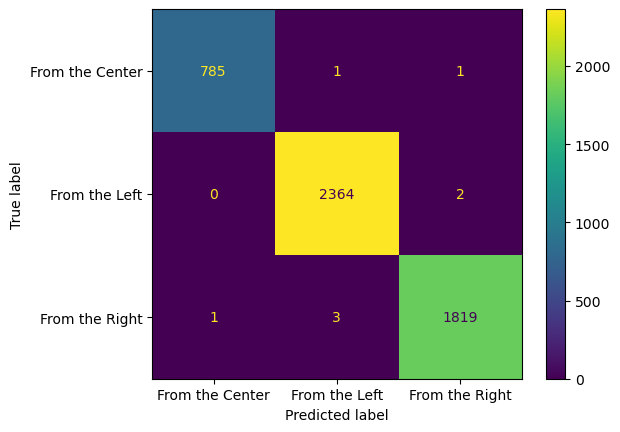

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

model= RandomForestClassifier(n_estimators=25)
model= model.fit(X_train, y_train)

predictions_train= model.predict(X_train)

disp= ConfusionMatrixDisplay(confusion_matrix(y_train, predictions_train),\
    display_labels=['From the Center', 'From the Left', 'From the Right'])
disp.plot()
print(f"accuracy (on X_train): {accuracy_score(y_train, predictions_train):.4f}")

We will compare the performance with our testing set

In [18]:
"Vectorize the validation data"
X_val= vectorizer.transform(X_val_raw).toarray()
print(f"X_val.shape= {X_val.shape}")
type(X_val)

X_val.shape= (1244, 50905)


numpy.ndarray

accuracy (on X_train): 0.6736


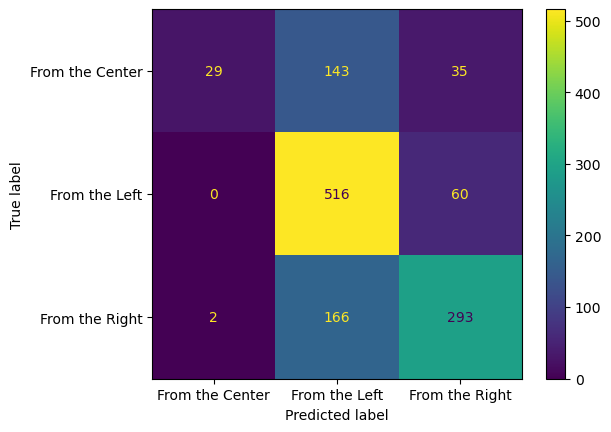

In [19]:
"predict with validation set"
predictions_val= model.predict(X_val)
disp= ConfusionMatrixDisplay(confusion_matrix(y_val, predictions_val),\
    display_labels=['From the Center', 'From the Left', 'From the Right'])
disp.plot()
print(f"accuracy (on X_train): {accuracy_score(y_val, predictions_val):.4f}")

We can see the performance is not as good as the training data set, but we can now play with the hyperparameters

In [20]:
from sklearn.metrics import log_loss

tune_model= True

def tuneModel(hyperparam_value):
    rf_model= RandomForestClassifier(n_estimators=hyperparam_value, random_state=5)
    rf_model.fit(X_train, y_train)
    y_train_pred_prob= rf_model.predict_proba(X_train)
    y_train_pred= rf_model.predict(X_train)
    y_val_pred_prob= rf_model.predict_proba(X_val)
    y_val_pred= rf_model.predict(X_val)
    train_loss= log_loss(y_train, y_train_pred_prob, labels=['From the Center','From the Left', 'From the Right'])
    train_acc= accuracy_score(y_train, y_train_pred)
    val_loss= log_loss(y_val, y_val_pred_prob, labels=['From the Center','From the Left', 'From the Right'])
    val_acc= accuracy_score(y_val, y_val_pred)
    return (train_loss, val_loss, train_acc, val_acc)

hyp_param_vals= list(range(10, 261, 50))
metrics= []

if tune_model:
    for hp in hyp_param_vals:
        metrics.append(tuneModel(hp))


[Text(0.5, 0, 'n_estimators'), Text(0, 0.5, 'loss (lower is better)')]

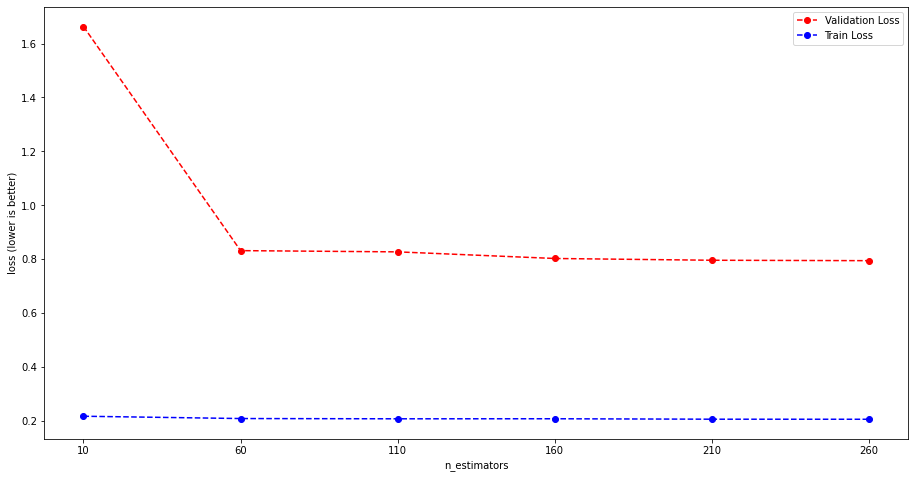

In [ ]:
"credit to nb_C_airline_tweets_take2 notebook"
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(12, 6))
ax= fig.add_axes([0, 0, 1, 1])
ax.plot(hyp_param_vals, [metric[1] for metric in metrics], '--ro')
ax.plot(hyp_param_vals, [metric[0] for metric in metrics], '--bo')
ax.legend(["Validation Loss", "Train Loss"], loc= 1)
ax.set_xticks(hyp_param_vals)
ax.set(xlabel= 'n_estimators', ylabel="loss (lower is better)")

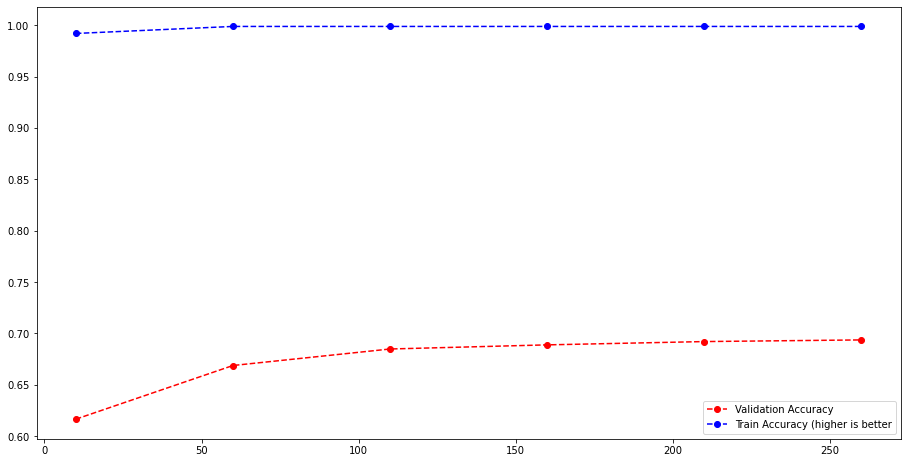

In [ ]:
"credit to nb_C_airline_tweets_take2 notebook"
fig= plt.figure(figsize=(12, 6))
ax= fig.add_axes([0,0,1,1])
ax.plot(hyp_param_vals, [metric[3] for metric in metrics], '--ro')
ax.plot(hyp_param_vals, [metric[2] for metric in metrics], '--bo')
ax.legend(["Validation Accuracy", "Train Accuracy (higher is better"])
plt.show()

We can that 100+ seems to be the best hyperparameter if we continue to use the Random Forest Classifier method